In [2]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import spacy
from spacy.matcher import Matcher
import numpy as np
#nlp = spacy.load('en_core_web_sm')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import spacy 
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [4]:
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'
spacy_model_dir='./wikipedia-pubmed-and-PMC-w2v'
nlp = spacy.load(spacy_model_dir)
srsS=pd.read_pickle(inS_dir)

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

tmpDf=technical_meta_data_df.drop_duplicates('Sample')

technical_meta_data_df=tmpDf.sample(n=tmpDf.shape[0],random_state=0)

#technical_meta_data_df.head()
##take only the top ten per study to avoid study bias
n=100
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=n)['Sample']

#subsampledSrs.head()

m=srsS.index.get_level_values(0).isin(subsampledSrs.values)

srsS_subS=srsS[m]

In [ ]:
srsS_subS.head()

In [5]:
attribVC=srsS_subS.index.get_level_values(1).value_counts()

In [7]:
srs_resetDf=srsS_subS.reset_index()
srs_resetDf.columns=['srs','attrib','word']

In [20]:
recurr_attrib=attribVC.index[attribVC>100]

In [98]:
recurr_attrib

Index(['SCIENTIFIC_NAME', 'TITLE', 'SUBMITTER_ID', 'BioSampleModel',
       'geo_loc_name', 'collection_date', 'DESCRIPTION', 'source_name',
       'lat_lon', 'strain',
       ...
       'sample_pool', 'history/previous land use method', 'time_of_day',
       'samp_storage_condition', 'Sample_description', 'subject_age_range',
       'age_days', 'exp_growth_medium', 'amniotic_fluid_color',
       'foetal_health_stat'],
      dtype='object', length=2888)

In [21]:
subRecurDf=srs_resetDf[srs_resetDf.attrib.isin(recurr_attrib)]

In [24]:
shuffledDf=subRecurDf.sample(subRecurDf.shape[0])
#.head(n=100)

In [103]:
subsetDf=shuffledDf.groupby('attrib').head(n=100)

In [104]:
inProcessDf=subsetDf

In [105]:
docs=nlp.pipe(inProcessDf['word'].tolist())

In [106]:
vectors=[doc.vector for doc in  tqdm(docs,total=inProcessDf.shape[0])]

doc_vectorDf=pd.DataFrame(vectors,index=inProcessDf.set_index(['srs','attrib','word']).index).astype(float)





  0%|          | 0/288800 [00:00<?, ?it/s]



  0%|          | 1030/288800 [00:00<00:28, 10209.94it/s]



  1%|          | 2224/288800 [00:00<00:25, 11066.15it/s]



  1%|          | 3544/288800 [00:00<00:24, 11742.11it/s]



  2%|▏         | 5039/288800 [00:00<00:22, 12538.64it/s]



  2%|▏         | 6391/288800 [00:00<00:22, 12731.53it/s]



  3%|▎         | 7886/288800 [00:00<00:21, 13101.85it/s]



  3%|▎         | 9313/288800 [00:00<00:21, 13266.68it/s]



  4%|▍         | 10844/288800 [00:00<00:20, 13521.41it/s]



  4%|▍         | 12328/288800 [00:00<00:20, 13669.27it/s]



  5%|▍         | 13788/288800 [00:01<00:19, 13761.55it/s]



  5%|▌         | 15207/288800 [00:01<00:19, 13797.96it/s]



  6%|▌         | 16655/288800 [00:01<00:19, 13853.43it/s]



  6%|▋         | 18193/288800 [00:01<00:19, 13968.74it/s]



  7%|▋         | 19789/288800 [00:01<00:19, 14112.31it/s]



  7%|▋         | 21366/288800 [00:01<00:18, 14222.05it/s]



  8%|▊         | 23014/288800 [00:01<00:18

In [112]:
g=doc_vectorDf.groupby('attrib')

In [113]:
print ('total # of attributes: ',len(g))

total # of attributes:  2888


In [114]:
enetityEmbeddingDf=g.mean()

In [115]:
#some of the data didn't have any reads
validEmbeddingDf=enetityEmbeddingDf[enetityEmbeddingDf.sum(axis=1).abs()>0]

In [116]:
def corr_df(df1,df2,metric='cosine' ):
    import scipy.spatial as sp
    M = 1 - sp.distance.cdist(df1, df2, metric)
    print (M.shape)
    return pd.DataFrame(data=M,index=df1.index,columns=df2.index)
corrDf=corr_df(validEmbeddingDf,validEmbeddingDf)

(2772, 2772)


In [117]:
corrDf.columns=list(corrDf.index)
corrDf.columns.name='attrib2'
corrDf.index.name='attrib1'
np.fill_diagonal(corrDf.as_matrix(),np.nan)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


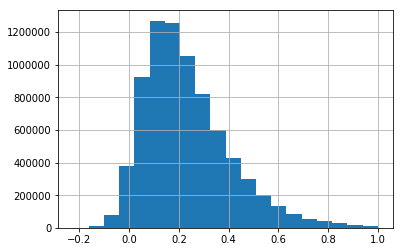

In [118]:
corrDf.unstack().dropna().hist(bins=20)

In [192]:
attribVC.loc['growth conditions']

572

In [222]:
#recurr_attribs=attribVC.index[attribVC>100]
tmpS=corrDf['isolation_source'].sort_values(ascending=False)#.loc['source name']#.dropna().sort_values(ascending=False)
tmpS[tmpS>0.7].to_frame()

,isolation_source
attrib1,
env_material,0.893872
environment (material),0.892051
bio_material,0.851678
description,0.845445
environment (feature),0.844320
env_matter,0.831080
biological_specimen,0.829247
environment_biome,0.821101
sample_type,0.820315


In [227]:
#geo_loc_name
attribTest='isolate'
['geo_loc_name','collection_date','sequencing method','disease','age','chip antibody']
inProcessDf[inProcessDf.attrib==attribTest].head(n=30)#collection_date


,srs,attrib,word
7917280,SRS1791483,isolate,I5
5552493,SRS1759242,isolate,donor S1
7204949,SRS749262,isolate,Fort Dix
10157542,SRS2558205,isolate,301530
2155111,SRS1179755,isolate,not applicable
9401390,SRS2149354,isolate,BdTR5g
2151923,SRS1533295,isolate,45
4790261,SRS1108010,isolate,not applicable
9179438,SRS1801138,isolate,Adult
6259954,ERS1470213,isolate,not applicable


In [225]:
recurr_attribs=attribVC.index[attribVC>100]
cosinDf=corrDf[attribTest].sort_values(ascending=False).head(n=20).to_frame()#.loc['source name']#.dropna().sort_values(ascending=False)
cosinDf['n']=attribVC.loc[:]

In [226]:
cosinDf

,SCIENTIFIC_NAME,n
attrib1,,
organism,0.979378,29037
Organism,0.933315,2894
host,0.905299,205511
host scientific name,0.901168,9909
host_scientific_name,0.892917,4297
host organism,0.892778,372
specific host,0.866071,11114
nat-host,0.861762,1516
specific_host,0.852756,14088


In [211]:
#print ("\n".join(attribVC.head(n=100).to_frame().index))

In [ ]:
"""
https://metamap.nlm.nih.gov/Docs/SemGroups_2013.txt

Activities & Behaviors
Anatomy
Chemicals & Drugs
Concepts & Ideas
Devices
Disorders
Genes & Molecular Sequences
Living Beings
Geographic Areas
Objects
Organizations
Physiology
Procedures

ACTI|Activities & Behaviors|T052|Activity
ACTI|Activities & Behaviors|T053|Behavior
ACTI|Activities & Behaviors|T056|Daily or Recreational Activity
ACTI|Activities & Behaviors|T051|Event
ACTI|Activities & Behaviors|T064|Governmental or Regulatory Activity
ACTI|Activities & Behaviors|T055|Individual Behavior
ACTI|Activities & Behaviors|T066|Machine Activity
ACTI|Activities & Behaviors|T057|Occupational Activity
ACTI|Activities & Behaviors|T054|Social Behavior
ANAT|Anatomy|T017|Anatomical Structure
ANAT|Anatomy|T029|Body Location or Region
ANAT|Anatomy|T023|Body Part, Organ, or Organ Component
ANAT|Anatomy|T030|Body Space or Junction
ANAT|Anatomy|T031|Body Substance
ANAT|Anatomy|T022|Body System
ANAT|Anatomy|T025|Cell
ANAT|Anatomy|T026|Cell Component
ANAT|Anatomy|T018|Embryonic Structure
ANAT|Anatomy|T021|Fully Formed Anatomical Structure
ANAT|Anatomy|T024|Tissue
CHEM|Chemicals & Drugs|T116|Amino Acid, Peptide, or Protein
CHEM|Chemicals & Drugs|T195|Antibiotic
CHEM|Chemicals & Drugs|T123|Biologically Active Substance
CHEM|Chemicals & Drugs|T122|Biomedical or Dental Material
CHEM|Chemicals & Drugs|T118|Carbohydrate
CHEM|Chemicals & Drugs|T103|Chemical
CHEM|Chemicals & Drugs|T120|Chemical Viewed Functionally
CHEM|Chemicals & Drugs|T104|Chemical Viewed Structurally
CHEM|Chemicals & Drugs|T200|Clinical Drug
CHEM|Chemicals & Drugs|T111|Eicosanoid
CHEM|Chemicals & Drugs|T196|Element, Ion, or Isotope
CHEM|Chemicals & Drugs|T126|Enzyme
CHEM|Chemicals & Drugs|T131|Hazardous or Poisonous Substance
CHEM|Chemicals & Drugs|T125|Hormone
CHEM|Chemicals & Drugs|T129|Immunologic Factor
CHEM|Chemicals & Drugs|T130|Indicator, Reagent, or Diagnostic Aid
CHEM|Chemicals & Drugs|T197|Inorganic Chemical
CHEM|Chemicals & Drugs|T119|Lipid
CHEM|Chemicals & Drugs|T124|Neuroreactive Substance or Biogenic Amine
CHEM|Chemicals & Drugs|T114|Nucleic Acid, Nucleoside, or Nucleotide
CHEM|Chemicals & Drugs|T109|Organic Chemical
CHEM|Chemicals & Drugs|T115|Organophosphorus Compound
CHEM|Chemicals & Drugs|T121|Pharmacologic Substance
CHEM|Chemicals & Drugs|T192|Receptor
CHEM|Chemicals & Drugs|T110|Steroid
CHEM|Chemicals & Drugs|T127|Vitamin
CONC|Concepts & Ideas|T185|Classification
CONC|Concepts & Ideas|T077|Conceptual Entity
CONC|Concepts & Ideas|T169|Functional Concept
CONC|Concepts & Ideas|T102|Group Attribute
CONC|Concepts & Ideas|T078|Idea or Concept
CONC|Concepts & Ideas|T170|Intellectual Product
CONC|Concepts & Ideas|T171|Language
CONC|Concepts & Ideas|T080|Qualitative Concept
CONC|Concepts & Ideas|T081|Quantitative Concept
CONC|Concepts & Ideas|T089|Regulation or Law
CONC|Concepts & Ideas|T082|Spatial Concept
CONC|Concepts & Ideas|T079|Temporal Concept
DEVI|Devices|T203|Drug Delivery Device
DEVI|Devices|T074|Medical Device
DEVI|Devices|T075|Research Device
DISO|Disorders|T020|Acquired Abnormality
DISO|Disorders|T190|Anatomical Abnormality
DISO|Disorders|T049|Cell or Molecular Dysfunction
DISO|Disorders|T019|Congenital Abnormality
DISO|Disorders|T047|Disease or Syndrome
DISO|Disorders|T050|Experimental Model of Disease
DISO|Disorders|T033|Finding
DISO|Disorders|T037|Injury or Poisoning
DISO|Disorders|T048|Mental or Behavioral Dysfunction
DISO|Disorders|T191|Neoplastic Process
DISO|Disorders|T046|Pathologic Function
DISO|Disorders|T184|Sign or Symptom
GENE|Genes & Molecular Sequences|T087|Amino Acid Sequence
GENE|Genes & Molecular Sequences|T088|Carbohydrate Sequence
GENE|Genes & Molecular Sequences|T028|Gene or Genome
GENE|Genes & Molecular Sequences|T085|Molecular Sequence
GENE|Genes & Molecular Sequences|T086|Nucleotide Sequence
GEOG|Geographic Areas|T083|Geographic Area
LIVB|Living Beings|T100|Age Group
LIVB|Living Beings|T011|Amphibian
LIVB|Living Beings|T008|Animal
LIVB|Living Beings|T194|Archaeon
LIVB|Living Beings|T007|Bacterium
LIVB|Living Beings|T012|Bird
LIVB|Living Beings|T204|Eukaryote
LIVB|Living Beings|T099|Family Group
LIVB|Living Beings|T013|Fish
LIVB|Living Beings|T004|Fungus
LIVB|Living Beings|T096|Group
LIVB|Living Beings|T016|Human
LIVB|Living Beings|T015|Mammal
LIVB|Living Beings|T001|Organism
LIVB|Living Beings|T101|Patient or Disabled Group
LIVB|Living Beings|T002|Plant
LIVB|Living Beings|T098|Population Group
LIVB|Living Beings|T097|Professional or Occupational Group
LIVB|Living Beings|T014|Reptile
LIVB|Living Beings|T010|Vertebrate
LIVB|Living Beings|T005|Virus
OBJC|Objects|T071|Entity
OBJC|Objects|T168|Food
OBJC|Objects|T073|Manufactured Object
OBJC|Objects|T072|Physical Object
OBJC|Objects|T167|Substance
OCCU|Occupations|T091|Biomedical Occupation or Discipline
OCCU|Occupations|T090|Occupation or Discipline
ORGA|Organizations|T093|Health Care Related Organization
ORGA|Organizations|T092|Organization
ORGA|Organizations|T094|Professional Society
ORGA|Organizations|T095|Self-help or Relief Organization
PHEN|Phenomena|T038|Biologic Function
PHEN|Phenomena|T069|Environmental Effect of Humans
PHEN|Phenomena|T068|Human-caused Phenomenon or Process
PHEN|Phenomena|T034|Laboratory or Test Result
PHEN|Phenomena|T070|Natural Phenomenon or Process
PHEN|Phenomena|T067|Phenomenon or Process
PHYS|Physiology|T043|Cell Function
PHYS|Physiology|T201|Clinical Attribute
PHYS|Physiology|T045|Genetic Function
PHYS|Physiology|T041|Mental Process
PHYS|Physiology|T044|Molecular Function
PHYS|Physiology|T032|Organism Attribute
PHYS|Physiology|T040|Organism Function
PHYS|Physiology|T042|Organ or Tissue Function
PHYS|Physiology|T039|Physiologic Function
PROC|Procedures|T060|Diagnostic Procedure
PROC|Procedures|T065|Educational Activity
PROC|Procedures|T058|Health Care Activity
PROC|Procedures|T059|Laboratory Procedure
PROC|Procedures|T063|Molecular Biology Research Technique
PROC|Procedures|T062|Research Activity
PROC|Procedures|T061|Therapeutic or Preventive Procedure
"""